In [160]:
import json
import os
import re
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from cassandra.cluster import Cluster

os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

# Docker Cassandra DB

In [161]:
!docker pull cassandra:latest
!docker network create cassandra
!docker run --rm -d --name bigdata_cassandra -p 9042:9042 --hostname cassandra --network cassandra cassandra

latest: Pulling from library/cassandra
Digest: sha256:8d3187f77bfa34340e72735d642df18bc6db6ac7e6545ab471f3bce3c10b5dad
Status: Image is up to date for cassandra:latest
docker.io/library/cassandra:latest


Error response from daemon: network with name cassandra already exists
docker: Error response from daemon: Conflict. The container name "/bigdata_cassandra" is already in use by container "aa97c0e37e859cc5adea44d498e71475a722194ce06f616d50e703625a3f02b6". You have to remove (or rename) that container to be able to reuse that name.
See 'docker run --help'.


In [162]:
# connect to cassandra
cluster = Cluster(protocol_version=5)
session = cluster.connect()  # default keyspace

Create Keyspace

In [163]:
statement = "CREATE KEYSPACE IF NOT EXISTS lockdown WITH REPLICATION = { 'class' : 'SimpleStrategy', 'replication_factor' : '1' };"
session.execute(statement)

Create Table

In [164]:
statement = "CREATE TABLE IF NOT EXISTS lockdown.covid (id int,created_at timestamp, cases int, country text, PRIMARY KEY (id, created_at)) WITH CLUSTERING ORDER BY (created_at ASC)"
session.execute(statement)

In [165]:
statement = "CREATE TABLE IF NOT EXISTS lockdown.co (id int, start_time timestamp, end_time timestamp, avg_emission float, PRIMARY KEY (id, start_time, end_time)) WITH CLUSTERING ORDER BY (start_time ASC)"
session.execute(statement)

In [166]:
covid_api = "https://api.covid19api.com/"
covid_api_path = "country/austria/status/confirmed?from=2020-01-01T00:00:00Z&to=2021-01-01T00:00:00Z"

response = requests.get(covid_api + covid_api_path)
covid_data_json = json.loads(response.text)
covid_data_json

[{'Country': 'Austria',
  'CountryCode': 'AT',
  'Province': '',
  'City': '',
  'CityCode': '',
  'Lat': '47.52',
  'Lon': '14.55',
  'Cases': 0,
  'Status': 'confirmed',
  'Date': '2020-01-22T00:00:00Z'},
 {'Country': 'Austria',
  'CountryCode': 'AT',
  'Province': '',
  'City': '',
  'CityCode': '',
  'Lat': '47.52',
  'Lon': '14.55',
  'Cases': 0,
  'Status': 'confirmed',
  'Date': '2020-01-23T00:00:00Z'},
 {'Country': 'Austria',
  'CountryCode': 'AT',
  'Province': '',
  'City': '',
  'CityCode': '',
  'Lat': '47.52',
  'Lon': '14.55',
  'Cases': 0,
  'Status': 'confirmed',
  'Date': '2020-01-24T00:00:00Z'},
 {'Country': 'Austria',
  'CountryCode': 'AT',
  'Province': '',
  'City': '',
  'CityCode': '',
  'Lat': '47.52',
  'Lon': '14.55',
  'Cases': 0,
  'Status': 'confirmed',
  'Date': '2020-01-25T00:00:00Z'},
 {'Country': 'Austria',
  'CountryCode': 'AT',
  'Province': '',
  'City': '',
  'CityCode': '',
  'Lat': '47.52',
  'Lon': '14.55',
  'Cases': 0,
  'Status': 'confirmed',


In [167]:
prepared_query = session.prepare('INSERT INTO lockdown.covid(id, created_at, cases, country) VALUES (?,?,?,?)')
for data in covid_data_json:
    date = int(re.sub("[^0-9]", "", data["Date"][:10]))
    session.execute(prepared_query,
                    (date, datetime.strptime(data["Date"], '%Y-%m-%dT%H:%M:%SZ'), data["Cases"], data["Country"]))

In [168]:
def pandas_factory(colnames, rows):
    return pd.DataFrame(rows, columns=colnames)


session.row_factory = pandas_factory
session.default_fetch_size = None

In [178]:
query = "SELECT created_at, cases, country FROM lockdown.covid"
rslt = session.execute(query, timeout=None)
covid_df = rslt._current_rows
covid_df.sort_values(by='created_at', inplace=True)
covid_df

,created_at,cases,country
293,2020-01-22,0,Austria
99,2020-01-23,0,Austria
246,2020-01-24,0,Austria
111,2020-01-25,0,Austria
177,2020-01-26,0,Austria
...,...,...,...
203,2020-12-28,349266,Austria
152,2020-12-29,350963,Austria
112,2020-12-30,353088,Austria
343,2020-12-31,356063,Austria


Text(0, 0.5, 'Cases')

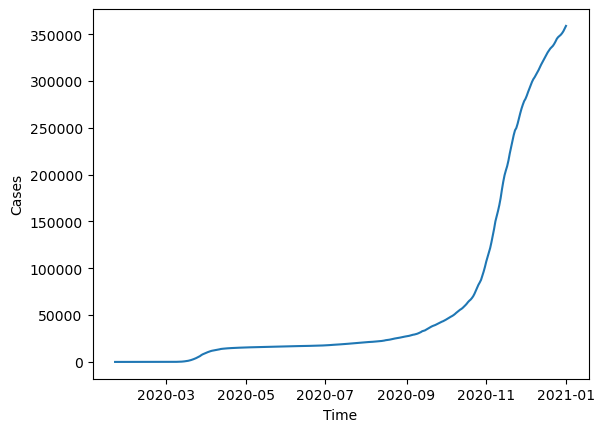

In [179]:
# covid_df["Date"] = covid_df["Date"].apply(lambda d: pd.to_datetime(str(d)))
plt.plot(covid_df["created_at"], covid_df['cases'])
plt.xlabel('Time')
plt.ylabel('Cases')

In [171]:
co_api = "https://api.v2.emissions-api.org/api/v2/carbonmonoxide/average.json?country=AT&begin=2020-01-01&end=2021-01-01"
co_api_key = ""
response = requests.get(co_api + co_api_key)
co_data_json = json.loads(response.text)
co_data_json

[{'average': 0.03358068296478854,
  'end': '2020-01-01T12:12:19.325000Z',
  'start': '2020-01-01T10:32:22.778000Z'},
 {'average': 0.032566260942753326,
  'end': '2020-01-02T11:53:26.264000Z',
  'start': '2020-01-02T11:52:50.145000Z'},
 {'average': 0.030046286170973498,
  'end': '2020-01-03T11:34:39.924000Z',
  'start': '2020-01-03T11:34:16.405000Z'},
 {'average': 0.030671005447705586,
  'end': '2020-01-04T12:56:09.570000Z',
  'start': '2020-01-04T11:15:36.664000Z'},
 {'average': 0.032007832100371954,
  'end': '2020-01-05T12:37:41.111000Z',
  'start': '2020-01-05T10:56:54.645000Z'},
 {'average': 0.03168427836940144,
  'end': '2020-01-06T12:18:38.933000Z',
  'start': '2020-01-06T10:38:25.106000Z'},
 {'average': 0.028889652563347704,
  'end': '2020-01-07T11:59:43.833000Z',
  'start': '2020-01-07T11:59:06.874000Z'},
 {'average': 0.02988642066096266,
  'end': '2020-01-08T13:21:42.997000Z',
  'start': '2020-01-08T11:40:19.692000Z'},
 {'average': 0.027939650363155773,
  'end': '2020-01-09T13:

In [172]:
prepared_query = session.prepare('INSERT INTO lockdown.co(id, start_time, end_time, avg_emission) VALUES (?,?,?,?)')
for data in co_data_json:
    date = int(re.sub("[^0-9]", "", data["start"][:10]))
    session.execute(prepared_query,
                    (date, datetime.strptime(data["start"], '%Y-%m-%dT%H:%M:%S.%fZ'),
                     datetime.strptime(data["end"], '%Y-%m-%dT%H:%M:%S.%fZ'), float(data["average"])))

In [180]:
query = "SELECT start_time, avg_emission FROM lockdown.co"
rslt = session.execute(query, timeout=None)
co_data = rslt._current_rows
co_data.sort_values(by='start_time', inplace=True)
co_data

,start_time,avg_emission
36,2020-01-01 10:32:22.778,0.033581
118,2020-01-02 11:52:50.145,0.032566
195,2020-01-03 11:34:16.405,0.030046
221,2020-01-04 11:15:36.664,0.030671
256,2020-01-05 10:56:54.645,0.032008
...,...,...
232,2020-12-27 12:02:50.474,0.032924
212,2020-12-28 13:24:22.058,0.032834
158,2020-12-29 13:05:07.534,0.031642
115,2020-12-30 12:46:18.808,0.031613


Text(0, 0.5, 'CO emission')

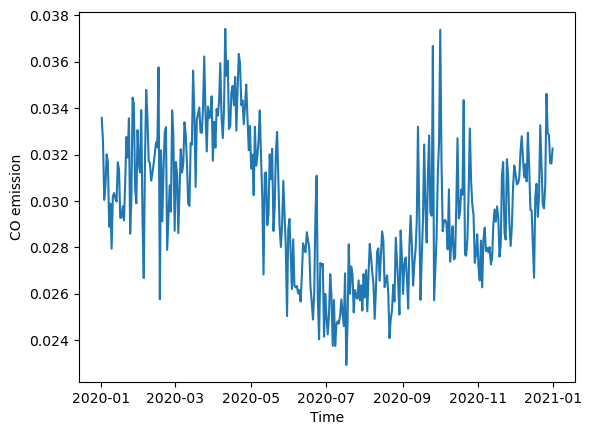

In [181]:
plt.plot(co_data["start_time"], co_data['avg_emission'])
plt.xlabel('Time')
plt.ylabel('CO emission')

In [182]:
# plt.plot(covid_df["Date"], co_df['average'], label="co")
# plt.plot(covid_df["Date"], covid_df['Cases'], label="covid")
# plt.xlabel('Time')

In [ ]:
# spark = SparkSession.builder.getOrCreate()
# sc = spark.sparkContext
# rddjson = sc.parallelize(jsonStr)
# covid_df2 = spark.read.json(rddjson)
# covid_df2